In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR_SGD_trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

In [8]:
'''for i in range(5):
    tmp=trainset[i]
    fig=plt.figure
    plt.imshow(np.transpose(tmp[0],(1,2,0)))
    plt.show()
    print(classes[tmp[1]])'''

'for i in range(5):\n    tmp=trainset[i]\n    fig=plt.figure\n    plt.imshow(np.transpose(tmp[0],(1,2,0)))\n    plt.show()\n    print(classes[tmp[1]])'

In [9]:
'''# get some random training images
dataiter = iter(CIFAR_SGD_trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)'''

"# get some random training images\ndataiter = iter(CIFAR_SGD_trainloader)\nimages, labels = dataiter.next()\nprint(images.shape)\n# show images\nimshow(torchvision.utils.make_grid(images))\n# print labels\nprint(' '.join('%5s' % classes[labels[j]] for j in range(4)))\n# print size of single image\nprint(images[1].shape)"

In [10]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [11]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    #num_items=8
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [12]:
'''cifar_iid_dataset=cifar_iid(trainset,2)
print(cifar_iid_dataset)'''

'cifar_iid_dataset=cifar_iid(trainset,2)\nprint(cifar_iid_dataset)'

In [13]:
'''num_clients=2
num_items=8

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=8\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [14]:
'''num_clients=2
num_items=5

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    for i in range(num_items):
        image=trainset[index_list[i]][0]
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        plt.imshow(np.transpose(image,(1,2,0)))
        plt.show()
        print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=5\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    for i in range(num_items):\n        image=trainset[index_list[i]][0]\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        plt.imshow(np.transpose(image,(1,2,0)))\n        plt.show()\n        print(classes[trainset[index_list[i]][1]])'

In [15]:
def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    #num_shards, num_imgs = 200, 250
    #num_shards, num_imgs = 200, 250
    class_per_user=1
    num_shards=num_users*class_per_user
    num_imgs=int(len(dataset)/num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([],dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels)

    labels=[]
    for element in dataset:
        labels.append(int(element[1]))
    #print(type(labels[0]))
    labels=np.array(labels)
    #labels=labels.astype('int64')
    # sort labels
    
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, class_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [16]:
def cifar_dirichlet(dataset, n_nets, alpha=0.5):
    '''
    if dataset == 'mnist':
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    '''
    #X_train=dataset[:][0]
    y_train=torch.zeros(len(dataset),dtype=torch.long)
    print(y_train.dtype)
    for a in range(len(dataset)):
        y_train[a]=(dataset[a][1])
    n_train = len(dataset)
    #X_train.shape[0]
    '''
    if partition == "homo":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_nets)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_nets)}
    '''
    #elif partition == "hetero-dir":
    min_size = 0
    K = 10
    N=len(dataset)
    N = y_train.shape[0]
    net_dataidx_map = {i: np.array([],dtype='int64') for i in range(n_nets)}

    while min_size < 10:
        idx_batch = [[] for _ in range(n_nets)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/n_nets) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_nets):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    #traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return net_dataidx_map
    #return (X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts)

In [17]:
'''cifar_noniid_dataset=cifar_noniid(trainset,2)
print(cifar_noniid_dataset)'''

'cifar_noniid_dataset=cifar_noniid(trainset,2)\nprint(cifar_noniid_dataset)'

In [18]:
'''num_clients=2
num_items=250*2

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=250*2\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [19]:
'''num_clients=2
num_items=5
num_imgs=250
cifar_noniid_dataset=cifar_noniid(trainset, num_clients)
#print(cifar_noniid_dataset)
for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    #print(index_list)
    #print(index_list[0])
    #print(type(index_list[0]))
    for y in range(2):
        for i in range(num_items):
            image=trainset[index_list[i+num_imgs*y]][0]
            #print(image)
            fig=plt.figure
            plt.imshow(np.transpose(image,(1,2,0)))
            plt.show()
            print(classes[trainset[index_list[i+num_imgs*y]][1]])'''

'num_clients=2\nnum_items=5\nnum_imgs=250\ncifar_noniid_dataset=cifar_noniid(trainset, num_clients)\n#print(cifar_noniid_dataset)\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    #print(index_list)\n    #print(index_list[0])\n    #print(type(index_list[0]))\n    for y in range(2):\n        for i in range(num_items):\n            image=trainset[index_list[i+num_imgs*y]][0]\n            #print(image)\n            fig=plt.figure\n            plt.imshow(np.transpose(image,(1,2,0)))\n            plt.show()\n            print(classes[trainset[index_list[i+num_imgs*y]][1]])'

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        
        
        
        self.conv1_global = nn.Conv2d(3, 32, 3)
        self.pool_global = nn.MaxPool2d(2, 2)
        self.conv2_global = nn.Conv2d(32, 64, 3)
        self.conv3_global = nn.Conv2d(64, 64, 3)
        self.fc1_global = nn.Linear(64 * 4 * 4, 64)
        self.fc2_global = nn.Linear(64, 10)
        self.freeze_model_global_weights()
        
        self.mse=nn.MSELoss()
        #self.fc3 = nn.Linear(84, 10)
    def freeze_model_global_weights(self):
        for n, m in self.named_modules():
            if hasattr(m, "weight") and m.weight is not None and 'global' in n:
                print(f"==> No gradient to {n}.weight")
                m.weight.requires_grad = False
                if m.weight.grad is not None:
                    print(f"==> Setting gradient of {n}.weight to None")
                    m.weight.grad = None

                if hasattr(m, "bias") and m.bias is not None and 'global' in n:
                    print(f"==> No gradient to {n}.bias")
                    m.bias.requires_grad = False

                    if m.bias.grad is not None:
                        print(f"==> Setting gradient of {n}.bias to None")
                        m.bias.grad = None
    def sync_online_and_global(self):
        state_dict=self.state_dict()
        for key in state_dict:
            if 'global' in key:
                x=(key.split("_global"))
                online=(x[0]+x[1])
                state_dict[key]=state_dict[online]
        self.load_state_dict(state_dict)
        
        
        
    def forward(self, x,online_target=False):
        if online_target==False:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = (F.relu(self.conv3(x)))
            x = x.view(-1, 64*4*4)
            x = F.relu(self.fc1(x))
            x = (self.fc2(x))
            return x
        else:
            x1=copy.deepcopy(x)
            
            
            x = self.pool(F.relu(self.conv1(x)))
            x1 = self.pool_global(F.relu(self.conv1_global(x1)))
            diff=self.mse(x,x1)
            
            x = self.pool(F.relu(self.conv2(x)))
            x1 = self.pool_global(F.relu(self.conv2_global(x1)))
            diff+=self.mse(x,x1)
            
            
            x = (F.relu(self.conv3(x)))
            x1 = (F.relu(self.conv3_global(x1)))
            diff+=self.mse(x,x1)
            
            x = x.view(-1, 64*4*4)
            x1 = x1.view(-1, 64*4*4)
            
            x = F.relu(self.fc1(x))
            x1 = F.relu(self.fc1_global(x1))
            diff+=self.mse(x,x1)
            
            
            x = (self.fc2(x))
            x1 = (self.fc2_global(x1))
            diff+=self.mse(x,x1)
            
            
            return x,diff
        
        




In [21]:
net = Net()
net.to(device)

==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to conv3_global.weight
==> No gradient to conv3_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (conv1_global): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool_global): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_global): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_global): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1_global): Linear(in_features=1024, out_features=64, bias=True)
  (fc2_global): Linear(in_features=64, out_features=10, bias=True)
  (mse): MSELoss()
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.5)
loss_train = []
acc_train=[]

In [23]:
for epoch in range(0):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(CIFAR_SGD_trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(labels)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        
    if epoch%1==0:
        loss_train.append(loss)
        print(f"epoch: {epoch}")
        print(' Average loss {:.3f}'.format( loss))
        for j in range(1):
            net.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
        acc_train.append(100 * correct / total)

    net.train()

    '''# 통계를 출력합니다.
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0'''

print('Finished Training')

Finished Training


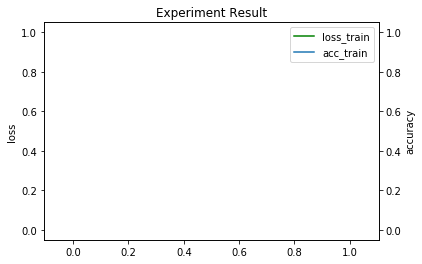

In [24]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


/home/dana/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy of the network on the 10000 test images: 10 %


In [26]:
class LocalUpdate(object):
    def __init__(self, lr,local_epoch,device,batch_size, dataset=None, idxs=None,alpha=0.001):
        self.lr=lr
        self.local_epoch=local_epoch
        self.device=device
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=batch_size, shuffle=True)
        self.alpha=alpha

    def train(self, net):
        net.sync_online_and_global()
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=self.lr)

        epoch_loss = []
        for iter in range(self.local_epoch):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                net.zero_grad()
                log_probs,activation_l2 = net(images,online_target=True)
                loss = self.loss_func(log_probs, labels)+self.alpha*activation_l2
                loss.backward()
                optimizer.step()
                #if batch_idx % 10 == 0:
                #    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                #               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

cifar10 FedAvg iid로 학습

In [27]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=501

==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to conv3_global.weight
==> No gradient to conv3_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias


In [28]:
weight_saved=FedAvg_model.state_dict()

In [29]:
C=0.05
num_clients=100
#CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [30]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=1,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 2.305
Accuracy of the network on the 10000 test images: 10.350000 %
This is global 1 epoch
 Average loss 2.302
Accuracy of the network on the 10000 test images: 14.310000 %
This is global 2 epoch
 Average loss 2.300
Accuracy of the network on the 10000 test images: 13.640000 %
This is global 3 epoch
 Average loss 2.298
Accuracy of the network on the 10000 test images: 13.910000 %
This is global 4 epoch
 Average loss 2.291
Accuracy of the network on the 10000 test images: 13.620000 %
This is global 5 epoch
 Average loss 2.278
Accuracy of the network on the 10000 test images: 21.690000 %
This is global 6 epoch
 Average loss 2.242
Accuracy of the network on the 10000 test images: 21.760000 %
This is global 7 epoch
 Average loss 2.186
Accuracy of the network on the 10000 test images: 19.930000 %
This is global 8 epoch
 Average loss 2.148
Accuracy of the network on the 10000 test images: 22.870000 %
This is global 9 epoch
 Average loss 2.096
Accuracy of the network on the 1000

 Average loss 1.393
Accuracy of the network on the 10000 test images: 52.510000 %
This is global 79 epoch
 Average loss 1.399
Accuracy of the network on the 10000 test images: 51.060000 %
This is global 80 epoch
 Average loss 1.398
Accuracy of the network on the 10000 test images: 52.120000 %
This is global 81 epoch
 Average loss 1.410
Accuracy of the network on the 10000 test images: 51.350000 %
This is global 82 epoch
 Average loss 1.391
Accuracy of the network on the 10000 test images: 50.950000 %
This is global 83 epoch
 Average loss 1.369
Accuracy of the network on the 10000 test images: 51.580000 %
This is global 84 epoch
 Average loss 1.355
Accuracy of the network on the 10000 test images: 51.560000 %
This is global 85 epoch
 Average loss 1.420
Accuracy of the network on the 10000 test images: 52.360000 %
This is global 86 epoch
 Average loss 1.414
Accuracy of the network on the 10000 test images: 51.440000 %
This is global 87 epoch
 Average loss 1.347
Accuracy of the network on

 Average loss 1.140
Accuracy of the network on the 10000 test images: 61.740000 %
This is global 156 epoch
 Average loss 1.135
Accuracy of the network on the 10000 test images: 60.950000 %
This is global 157 epoch
 Average loss 1.069
Accuracy of the network on the 10000 test images: 59.680000 %
This is global 158 epoch
 Average loss 1.095
Accuracy of the network on the 10000 test images: 62.090000 %
This is global 159 epoch
 Average loss 1.113
Accuracy of the network on the 10000 test images: 60.630000 %
This is global 160 epoch
 Average loss 1.074
Accuracy of the network on the 10000 test images: 62.230000 %
This is global 161 epoch
 Average loss 1.090
Accuracy of the network on the 10000 test images: 62.320000 %
This is global 162 epoch
 Average loss 1.057
Accuracy of the network on the 10000 test images: 62.180000 %
This is global 163 epoch
 Average loss 1.099
Accuracy of the network on the 10000 test images: 62.920000 %
This is global 164 epoch
 Average loss 1.053
Accuracy of the n

 Average loss 0.884
Accuracy of the network on the 10000 test images: 66.010000 %
This is global 233 epoch
 Average loss 0.865
Accuracy of the network on the 10000 test images: 67.480000 %
This is global 234 epoch
 Average loss 0.846
Accuracy of the network on the 10000 test images: 66.950000 %
This is global 235 epoch
 Average loss 0.880
Accuracy of the network on the 10000 test images: 67.880000 %
This is global 236 epoch
 Average loss 0.935
Accuracy of the network on the 10000 test images: 65.930000 %
This is global 237 epoch
 Average loss 0.880
Accuracy of the network on the 10000 test images: 67.040000 %
This is global 238 epoch
 Average loss 0.858
Accuracy of the network on the 10000 test images: 67.380000 %
This is global 239 epoch
 Average loss 0.932
Accuracy of the network on the 10000 test images: 67.440000 %
This is global 240 epoch
 Average loss 0.902
Accuracy of the network on the 10000 test images: 67.280000 %
This is global 241 epoch
 Average loss 0.905
Accuracy of the n

 Average loss 0.682
Accuracy of the network on the 10000 test images: 68.440000 %
This is global 310 epoch
 Average loss 0.848
Accuracy of the network on the 10000 test images: 69.590000 %
This is global 311 epoch
 Average loss 0.790
Accuracy of the network on the 10000 test images: 69.520000 %
This is global 312 epoch
 Average loss 0.790
Accuracy of the network on the 10000 test images: 69.900000 %
This is global 313 epoch
 Average loss 0.759
Accuracy of the network on the 10000 test images: 69.800000 %
This is global 314 epoch
 Average loss 0.705
Accuracy of the network on the 10000 test images: 69.460000 %
This is global 315 epoch
 Average loss 0.748
Accuracy of the network on the 10000 test images: 70.070000 %
This is global 316 epoch
 Average loss 0.696
Accuracy of the network on the 10000 test images: 68.940000 %
This is global 317 epoch
 Average loss 0.755
Accuracy of the network on the 10000 test images: 69.620000 %
This is global 318 epoch
 Average loss 0.692
Accuracy of the n

 Average loss 0.626
Accuracy of the network on the 10000 test images: 69.450000 %
This is global 387 epoch
 Average loss 0.652
Accuracy of the network on the 10000 test images: 71.430000 %
This is global 388 epoch
 Average loss 0.581
Accuracy of the network on the 10000 test images: 69.530000 %
This is global 389 epoch
 Average loss 0.643
Accuracy of the network on the 10000 test images: 69.830000 %
This is global 390 epoch
 Average loss 0.666
Accuracy of the network on the 10000 test images: 70.110000 %
This is global 391 epoch
 Average loss 0.552
Accuracy of the network on the 10000 test images: 71.310000 %
This is global 392 epoch
 Average loss 0.590
Accuracy of the network on the 10000 test images: 70.070000 %
This is global 393 epoch
 Average loss 0.594
Accuracy of the network on the 10000 test images: 70.980000 %
This is global 394 epoch
 Average loss 0.632
Accuracy of the network on the 10000 test images: 70.370000 %
This is global 395 epoch
 Average loss 0.648
Accuracy of the n

 Average loss 0.565
Accuracy of the network on the 10000 test images: 70.010000 %
This is global 464 epoch
 Average loss 0.466
Accuracy of the network on the 10000 test images: 70.370000 %
This is global 465 epoch
 Average loss 0.512
Accuracy of the network on the 10000 test images: 70.560000 %
This is global 466 epoch
 Average loss 0.576
Accuracy of the network on the 10000 test images: 70.750000 %
This is global 467 epoch
 Average loss 0.507
Accuracy of the network on the 10000 test images: 70.630000 %
This is global 468 epoch
 Average loss 0.511
Accuracy of the network on the 10000 test images: 70.960000 %
This is global 469 epoch
 Average loss 0.572
Accuracy of the network on the 10000 test images: 70.820000 %
This is global 470 epoch
 Average loss 0.545
Accuracy of the network on the 10000 test images: 70.850000 %
This is global 471 epoch
 Average loss 0.501
Accuracy of the network on the 10000 test images: 70.540000 %
This is global 472 epoch
 Average loss 0.511
Accuracy of the n

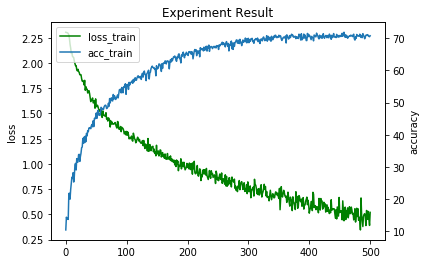

In [31]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [32]:
PATH = './data/CIFAR_iid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

cifar10 FedAvg Non-iid로 학습


In [33]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=5001

==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to conv3_global.weight
==> No gradient to conv3_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias


In [34]:
weight_saved=FedAvg_model.state_dict()

In [35]:
C=0.05
num_clients=100
CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [36]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=1,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 0.719
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1 epoch
 Average loss 0.492
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2 epoch
 Average loss 0.552
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3 epoch
 Average loss 0.556
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4 epoch
 Average loss 0.312
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 5 epoch
 Average loss 0.419
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 6 epoch
 Average loss 0.318
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 7 epoch
 Average loss 0.178
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 8 epoch
 Average loss 0.284
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 9 epoch
 Average loss 0.255
Accuracy of the network on the 1000

 Average loss 0.246
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 79 epoch
 Average loss 0.349
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 80 epoch
 Average loss 0.348
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 81 epoch
 Average loss 0.223
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 82 epoch
 Average loss 0.203
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 83 epoch
 Average loss 0.252
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 84 epoch
 Average loss 0.278
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 85 epoch
 Average loss 0.188
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 86 epoch
 Average loss 0.363
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 87 epoch
 Average loss 0.238
Accuracy of the network on

 Average loss 0.201
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 156 epoch
 Average loss 0.197
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 157 epoch
 Average loss 0.355
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 158 epoch
 Average loss 0.257
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 159 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 160 epoch
 Average loss 0.416
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 161 epoch
 Average loss 0.282
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 162 epoch
 Average loss 0.229
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 163 epoch
 Average loss 0.219
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 164 epoch
 Average loss 0.291
Accuracy of the n

 Average loss 0.416
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 233 epoch
 Average loss 0.350
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 234 epoch
 Average loss 0.154
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 235 epoch
 Average loss 0.242
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 236 epoch
 Average loss 0.307
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 237 epoch
 Average loss 0.227
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 238 epoch
 Average loss 0.247
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 239 epoch
 Average loss 0.240
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 240 epoch
 Average loss 0.238
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 241 epoch
 Average loss 0.233
Accuracy of the n

 Average loss 0.153
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 310 epoch
 Average loss 0.341
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 311 epoch
 Average loss 0.199
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 312 epoch
 Average loss 0.238
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 313 epoch
 Average loss 0.293
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 314 epoch
 Average loss 0.230
Accuracy of the network on the 10000 test images: 12.290000 %
This is global 315 epoch
 Average loss 0.203
Accuracy of the network on the 10000 test images: 13.560000 %
This is global 316 epoch
 Average loss 0.169
Accuracy of the network on the 10000 test images: 14.250000 %
This is global 317 epoch
 Average loss 0.254
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 318 epoch
 Average loss 0.209
Accuracy of the n

 Average loss 0.221
Accuracy of the network on the 10000 test images: 17.040000 %
This is global 387 epoch
 Average loss 0.213
Accuracy of the network on the 10000 test images: 16.440000 %
This is global 388 epoch
 Average loss 0.216
Accuracy of the network on the 10000 test images: 12.810000 %
This is global 389 epoch
 Average loss 0.210
Accuracy of the network on the 10000 test images: 10.260000 %
This is global 390 epoch
 Average loss 0.286
Accuracy of the network on the 10000 test images: 10.570000 %
This is global 391 epoch
 Average loss 0.183
Accuracy of the network on the 10000 test images: 17.190000 %
This is global 392 epoch
 Average loss 0.198
Accuracy of the network on the 10000 test images: 16.030000 %
This is global 393 epoch
 Average loss 0.258
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 394 epoch
 Average loss 0.209
Accuracy of the network on the 10000 test images: 11.830000 %
This is global 395 epoch
 Average loss 0.341
Accuracy of the n

 Average loss 0.152
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 464 epoch
 Average loss 0.252
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 465 epoch
 Average loss 0.392
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 466 epoch
 Average loss 0.273
Accuracy of the network on the 10000 test images: 12.850000 %
This is global 467 epoch
 Average loss 0.219
Accuracy of the network on the 10000 test images: 17.190000 %
This is global 468 epoch
 Average loss 0.246
Accuracy of the network on the 10000 test images: 14.180000 %
This is global 469 epoch
 Average loss 0.163
Accuracy of the network on the 10000 test images: 13.710000 %
This is global 470 epoch
 Average loss 0.183
Accuracy of the network on the 10000 test images: 12.490000 %
This is global 471 epoch
 Average loss 0.223
Accuracy of the network on the 10000 test images: 18.990000 %
This is global 472 epoch
 Average loss 0.201
Accuracy of the n

 Average loss 0.180
Accuracy of the network on the 10000 test images: 18.260000 %
This is global 541 epoch
 Average loss 0.260
Accuracy of the network on the 10000 test images: 17.000000 %
This is global 542 epoch
 Average loss 0.186
Accuracy of the network on the 10000 test images: 18.880000 %
This is global 543 epoch
 Average loss 0.192
Accuracy of the network on the 10000 test images: 19.600000 %
This is global 544 epoch
 Average loss 0.170
Accuracy of the network on the 10000 test images: 17.060000 %
This is global 545 epoch
 Average loss 0.188
Accuracy of the network on the 10000 test images: 18.370000 %
This is global 546 epoch
 Average loss 0.247
Accuracy of the network on the 10000 test images: 20.270000 %
This is global 547 epoch
 Average loss 0.169
Accuracy of the network on the 10000 test images: 13.420000 %
This is global 548 epoch
 Average loss 0.257
Accuracy of the network on the 10000 test images: 14.260000 %
This is global 549 epoch
 Average loss 0.243
Accuracy of the n

 Average loss 0.157
Accuracy of the network on the 10000 test images: 14.840000 %
This is global 618 epoch
 Average loss 0.121
Accuracy of the network on the 10000 test images: 18.880000 %
This is global 619 epoch
 Average loss 0.243
Accuracy of the network on the 10000 test images: 19.160000 %
This is global 620 epoch
 Average loss 0.225
Accuracy of the network on the 10000 test images: 20.790000 %
This is global 621 epoch
 Average loss 0.173
Accuracy of the network on the 10000 test images: 22.320000 %
This is global 622 epoch
 Average loss 0.177
Accuracy of the network on the 10000 test images: 15.900000 %
This is global 623 epoch
 Average loss 0.188
Accuracy of the network on the 10000 test images: 14.250000 %
This is global 624 epoch
 Average loss 0.204
Accuracy of the network on the 10000 test images: 12.060000 %
This is global 625 epoch
 Average loss 0.213
Accuracy of the network on the 10000 test images: 12.490000 %
This is global 626 epoch
 Average loss 0.245
Accuracy of the n

 Average loss 0.212
Accuracy of the network on the 10000 test images: 16.780000 %
This is global 695 epoch
 Average loss 0.241
Accuracy of the network on the 10000 test images: 25.560000 %
This is global 696 epoch
 Average loss 0.169
Accuracy of the network on the 10000 test images: 15.410000 %
This is global 697 epoch
 Average loss 0.273
Accuracy of the network on the 10000 test images: 10.520000 %
This is global 698 epoch
 Average loss 0.220
Accuracy of the network on the 10000 test images: 26.800000 %
This is global 699 epoch
 Average loss 0.175
Accuracy of the network on the 10000 test images: 24.420000 %
This is global 700 epoch
 Average loss 0.148
Accuracy of the network on the 10000 test images: 20.690000 %
This is global 701 epoch
 Average loss 0.254
Accuracy of the network on the 10000 test images: 18.610000 %
This is global 702 epoch
 Average loss 0.169
Accuracy of the network on the 10000 test images: 21.350000 %
This is global 703 epoch
 Average loss 0.154
Accuracy of the n

 Average loss 0.172
Accuracy of the network on the 10000 test images: 15.810000 %
This is global 772 epoch
 Average loss 0.247
Accuracy of the network on the 10000 test images: 24.560000 %
This is global 773 epoch
 Average loss 0.272
Accuracy of the network on the 10000 test images: 16.790000 %
This is global 774 epoch
 Average loss 0.212
Accuracy of the network on the 10000 test images: 22.100000 %
This is global 775 epoch
 Average loss 0.261
Accuracy of the network on the 10000 test images: 16.130000 %
This is global 776 epoch
 Average loss 0.192
Accuracy of the network on the 10000 test images: 19.410000 %
This is global 777 epoch
 Average loss 0.230
Accuracy of the network on the 10000 test images: 15.570000 %
This is global 778 epoch
 Average loss 0.188
Accuracy of the network on the 10000 test images: 17.720000 %
This is global 779 epoch
 Average loss 0.248
Accuracy of the network on the 10000 test images: 23.360000 %
This is global 780 epoch
 Average loss 0.223
Accuracy of the n

 Average loss 0.140
Accuracy of the network on the 10000 test images: 30.470000 %
This is global 849 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 21.610000 %
This is global 850 epoch
 Average loss 0.198
Accuracy of the network on the 10000 test images: 23.510000 %
This is global 851 epoch
 Average loss 0.146
Accuracy of the network on the 10000 test images: 28.780000 %
This is global 852 epoch
 Average loss 0.128
Accuracy of the network on the 10000 test images: 19.110000 %
This is global 853 epoch
 Average loss 0.240
Accuracy of the network on the 10000 test images: 15.500000 %
This is global 854 epoch
 Average loss 0.277
Accuracy of the network on the 10000 test images: 18.690000 %
This is global 855 epoch
 Average loss 0.261
Accuracy of the network on the 10000 test images: 25.330000 %
This is global 856 epoch
 Average loss 0.236
Accuracy of the network on the 10000 test images: 23.820000 %
This is global 857 epoch
 Average loss 0.183
Accuracy of the n

 Average loss 0.222
Accuracy of the network on the 10000 test images: 24.610000 %
This is global 926 epoch
 Average loss 0.203
Accuracy of the network on the 10000 test images: 33.780000 %
This is global 927 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 33.290000 %
This is global 928 epoch
 Average loss 0.148
Accuracy of the network on the 10000 test images: 22.660000 %
This is global 929 epoch
 Average loss 0.192
Accuracy of the network on the 10000 test images: 31.640000 %
This is global 930 epoch
 Average loss 0.221
Accuracy of the network on the 10000 test images: 24.670000 %
This is global 931 epoch
 Average loss 0.112
Accuracy of the network on the 10000 test images: 21.110000 %
This is global 932 epoch
 Average loss 0.169
Accuracy of the network on the 10000 test images: 20.740000 %
This is global 933 epoch
 Average loss 0.248
Accuracy of the network on the 10000 test images: 27.050000 %
This is global 934 epoch
 Average loss 0.137
Accuracy of the n

 Average loss 0.230
Accuracy of the network on the 10000 test images: 30.870000 %
This is global 1003 epoch
 Average loss 0.161
Accuracy of the network on the 10000 test images: 32.240000 %
This is global 1004 epoch
 Average loss 0.208
Accuracy of the network on the 10000 test images: 34.260000 %
This is global 1005 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 29.600000 %
This is global 1006 epoch
 Average loss 0.182
Accuracy of the network on the 10000 test images: 24.160000 %
This is global 1007 epoch
 Average loss 0.225
Accuracy of the network on the 10000 test images: 30.810000 %
This is global 1008 epoch
 Average loss 0.165
Accuracy of the network on the 10000 test images: 30.190000 %
This is global 1009 epoch
 Average loss 0.192
Accuracy of the network on the 10000 test images: 31.670000 %
This is global 1010 epoch
 Average loss 0.184
Accuracy of the network on the 10000 test images: 29.950000 %
This is global 1011 epoch
 Average loss 0.186
Accuracy

 Average loss 0.182
Accuracy of the network on the 10000 test images: 32.220000 %
This is global 1079 epoch
 Average loss 0.135
Accuracy of the network on the 10000 test images: 24.770000 %
This is global 1080 epoch
 Average loss 0.233
Accuracy of the network on the 10000 test images: 30.280000 %
This is global 1081 epoch
 Average loss 0.174
Accuracy of the network on the 10000 test images: 26.320000 %
This is global 1082 epoch
 Average loss 0.211
Accuracy of the network on the 10000 test images: 32.630000 %
This is global 1083 epoch
 Average loss 0.123
Accuracy of the network on the 10000 test images: 26.480000 %
This is global 1084 epoch
 Average loss 0.217
Accuracy of the network on the 10000 test images: 33.290000 %
This is global 1085 epoch
 Average loss 0.203
Accuracy of the network on the 10000 test images: 36.140000 %
This is global 1086 epoch
 Average loss 0.166
Accuracy of the network on the 10000 test images: 23.970000 %
This is global 1087 epoch
 Average loss 0.179
Accuracy

 Average loss 0.168
Accuracy of the network on the 10000 test images: 28.590000 %
This is global 1155 epoch
 Average loss 0.146
Accuracy of the network on the 10000 test images: 29.020000 %
This is global 1156 epoch
 Average loss 0.108
Accuracy of the network on the 10000 test images: 32.190000 %
This is global 1157 epoch
 Average loss 0.185
Accuracy of the network on the 10000 test images: 27.040000 %
This is global 1158 epoch
 Average loss 0.216
Accuracy of the network on the 10000 test images: 40.120000 %
This is global 1159 epoch
 Average loss 0.115
Accuracy of the network on the 10000 test images: 31.680000 %
This is global 1160 epoch
 Average loss 0.160
Accuracy of the network on the 10000 test images: 36.150000 %
This is global 1161 epoch
 Average loss 0.163
Accuracy of the network on the 10000 test images: 38.470000 %
This is global 1162 epoch
 Average loss 0.143
Accuracy of the network on the 10000 test images: 34.290000 %
This is global 1163 epoch
 Average loss 0.131
Accuracy

 Average loss 0.254
Accuracy of the network on the 10000 test images: 34.130000 %
This is global 1231 epoch
 Average loss 0.199
Accuracy of the network on the 10000 test images: 36.460000 %
This is global 1232 epoch
 Average loss 0.203
Accuracy of the network on the 10000 test images: 28.170000 %
This is global 1233 epoch
 Average loss 0.142
Accuracy of the network on the 10000 test images: 30.760000 %
This is global 1234 epoch
 Average loss 0.214
Accuracy of the network on the 10000 test images: 40.330000 %
This is global 1235 epoch
 Average loss 0.129
Accuracy of the network on the 10000 test images: 42.880000 %
This is global 1236 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 32.940000 %
This is global 1237 epoch
 Average loss 0.212
Accuracy of the network on the 10000 test images: 28.920000 %
This is global 1238 epoch
 Average loss 0.180
Accuracy of the network on the 10000 test images: 38.180000 %
This is global 1239 epoch
 Average loss 0.134
Accuracy

 Average loss 0.148
Accuracy of the network on the 10000 test images: 34.610000 %
This is global 1307 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 30.640000 %
This is global 1308 epoch
 Average loss 0.123
Accuracy of the network on the 10000 test images: 40.010000 %
This is global 1309 epoch
 Average loss 0.168
Accuracy of the network on the 10000 test images: 42.030000 %
This is global 1310 epoch
 Average loss 0.130
Accuracy of the network on the 10000 test images: 32.000000 %
This is global 1311 epoch
 Average loss 0.194
Accuracy of the network on the 10000 test images: 39.260000 %
This is global 1312 epoch
 Average loss 0.157
Accuracy of the network on the 10000 test images: 20.740000 %
This is global 1313 epoch
 Average loss 0.255
Accuracy of the network on the 10000 test images: 33.080000 %
This is global 1314 epoch
 Average loss 0.181
Accuracy of the network on the 10000 test images: 21.680000 %
This is global 1315 epoch
 Average loss 0.239
Accuracy

 Average loss 0.153
Accuracy of the network on the 10000 test images: 27.750000 %
This is global 1383 epoch
 Average loss 0.178
Accuracy of the network on the 10000 test images: 39.170000 %
This is global 1384 epoch
 Average loss 0.157
Accuracy of the network on the 10000 test images: 39.960000 %
This is global 1385 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 32.360000 %
This is global 1386 epoch
 Average loss 0.115
Accuracy of the network on the 10000 test images: 43.110000 %
This is global 1387 epoch
 Average loss 0.125
Accuracy of the network on the 10000 test images: 37.250000 %
This is global 1388 epoch
 Average loss 0.199
Accuracy of the network on the 10000 test images: 43.740000 %
This is global 1389 epoch
 Average loss 0.123
Accuracy of the network on the 10000 test images: 40.310000 %
This is global 1390 epoch
 Average loss 0.173
Accuracy of the network on the 10000 test images: 36.290000 %
This is global 1391 epoch
 Average loss 0.143
Accuracy

 Average loss 0.158
Accuracy of the network on the 10000 test images: 39.220000 %
This is global 1459 epoch
 Average loss 0.138
Accuracy of the network on the 10000 test images: 42.060000 %
This is global 1460 epoch
 Average loss 0.122
Accuracy of the network on the 10000 test images: 40.420000 %
This is global 1461 epoch
 Average loss 0.103
Accuracy of the network on the 10000 test images: 41.700000 %
This is global 1462 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 40.660000 %
This is global 1463 epoch
 Average loss 0.123
Accuracy of the network on the 10000 test images: 39.520000 %
This is global 1464 epoch
 Average loss 0.147
Accuracy of the network on the 10000 test images: 35.690000 %
This is global 1465 epoch
 Average loss 0.252
Accuracy of the network on the 10000 test images: 38.460000 %
This is global 1466 epoch
 Average loss 0.142
Accuracy of the network on the 10000 test images: 27.390000 %
This is global 1467 epoch
 Average loss 0.154
Accuracy

 Average loss 0.160
Accuracy of the network on the 10000 test images: 45.010000 %
This is global 1535 epoch
 Average loss 0.137
Accuracy of the network on the 10000 test images: 44.770000 %
This is global 1536 epoch
 Average loss 0.134
Accuracy of the network on the 10000 test images: 43.020000 %
This is global 1537 epoch
 Average loss 0.138
Accuracy of the network on the 10000 test images: 45.000000 %
This is global 1538 epoch
 Average loss 0.108
Accuracy of the network on the 10000 test images: 45.220000 %
This is global 1539 epoch
 Average loss 0.162
Accuracy of the network on the 10000 test images: 50.580000 %
This is global 1540 epoch
 Average loss 0.097
Accuracy of the network on the 10000 test images: 42.610000 %
This is global 1541 epoch
 Average loss 0.176
Accuracy of the network on the 10000 test images: 36.550000 %
This is global 1542 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 44.520000 %
This is global 1543 epoch
 Average loss 0.123
Accuracy

 Average loss 0.124
Accuracy of the network on the 10000 test images: 41.890000 %
This is global 1611 epoch
 Average loss 0.079
Accuracy of the network on the 10000 test images: 39.260000 %
This is global 1612 epoch
 Average loss 0.132
Accuracy of the network on the 10000 test images: 41.870000 %
This is global 1613 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 38.990000 %
This is global 1614 epoch
 Average loss 0.176
Accuracy of the network on the 10000 test images: 49.830000 %
This is global 1615 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 42.480000 %
This is global 1616 epoch
 Average loss 0.133
Accuracy of the network on the 10000 test images: 39.280000 %
This is global 1617 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 45.890000 %
This is global 1618 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 41.620000 %
This is global 1619 epoch
 Average loss 0.133
Accuracy

 Average loss 0.130
Accuracy of the network on the 10000 test images: 48.170000 %
This is global 1687 epoch
 Average loss 0.133
Accuracy of the network on the 10000 test images: 39.400000 %
This is global 1688 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 42.390000 %
This is global 1689 epoch
 Average loss 0.190
Accuracy of the network on the 10000 test images: 52.370000 %
This is global 1690 epoch
 Average loss 0.091
Accuracy of the network on the 10000 test images: 42.600000 %
This is global 1691 epoch
 Average loss 0.133
Accuracy of the network on the 10000 test images: 43.140000 %
This is global 1692 epoch
 Average loss 0.156
Accuracy of the network on the 10000 test images: 46.230000 %
This is global 1693 epoch
 Average loss 0.156
Accuracy of the network on the 10000 test images: 47.330000 %
This is global 1694 epoch
 Average loss 0.137
Accuracy of the network on the 10000 test images: 45.600000 %
This is global 1695 epoch
 Average loss 0.129
Accuracy

 Average loss 0.143
Accuracy of the network on the 10000 test images: 46.160000 %
This is global 1763 epoch
 Average loss 0.146
Accuracy of the network on the 10000 test images: 44.260000 %
This is global 1764 epoch
 Average loss 0.132
Accuracy of the network on the 10000 test images: 34.530000 %
This is global 1765 epoch
 Average loss 0.153
Accuracy of the network on the 10000 test images: 49.790000 %
This is global 1766 epoch
 Average loss 0.121
Accuracy of the network on the 10000 test images: 42.910000 %
This is global 1767 epoch
 Average loss 0.165
Accuracy of the network on the 10000 test images: 33.510000 %
This is global 1768 epoch
 Average loss 0.170
Accuracy of the network on the 10000 test images: 44.450000 %
This is global 1769 epoch
 Average loss 0.173
Accuracy of the network on the 10000 test images: 45.190000 %
This is global 1770 epoch
 Average loss 0.166
Accuracy of the network on the 10000 test images: 26.820000 %
This is global 1771 epoch
 Average loss 0.230
Accuracy

 Average loss 0.189
Accuracy of the network on the 10000 test images: 49.470000 %
This is global 1839 epoch
 Average loss 0.117
Accuracy of the network on the 10000 test images: 41.410000 %
This is global 1840 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 38.680000 %
This is global 1841 epoch
 Average loss 0.158
Accuracy of the network on the 10000 test images: 46.730000 %
This is global 1842 epoch
 Average loss 0.113
Accuracy of the network on the 10000 test images: 44.270000 %
This is global 1843 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 44.500000 %
This is global 1844 epoch
 Average loss 0.163
Accuracy of the network on the 10000 test images: 48.990000 %
This is global 1845 epoch
 Average loss 0.112
Accuracy of the network on the 10000 test images: 42.680000 %
This is global 1846 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 44.220000 %
This is global 1847 epoch
 Average loss 0.117
Accuracy

 Average loss 0.079
Accuracy of the network on the 10000 test images: 41.430000 %
This is global 1915 epoch
 Average loss 0.167
Accuracy of the network on the 10000 test images: 47.450000 %
This is global 1916 epoch
 Average loss 0.094
Accuracy of the network on the 10000 test images: 50.530000 %
This is global 1917 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 52.090000 %
This is global 1918 epoch
 Average loss 0.091
Accuracy of the network on the 10000 test images: 52.480000 %
This is global 1919 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 39.910000 %
This is global 1920 epoch
 Average loss 0.161
Accuracy of the network on the 10000 test images: 45.120000 %
This is global 1921 epoch
 Average loss 0.125
Accuracy of the network on the 10000 test images: 41.440000 %
This is global 1922 epoch
 Average loss 0.145
Accuracy of the network on the 10000 test images: 48.780000 %
This is global 1923 epoch
 Average loss 0.093
Accuracy

 Average loss 0.098
Accuracy of the network on the 10000 test images: 41.130000 %
This is global 1991 epoch
 Average loss 0.181
Accuracy of the network on the 10000 test images: 48.500000 %
This is global 1992 epoch
 Average loss 0.115
Accuracy of the network on the 10000 test images: 34.390000 %
This is global 1993 epoch
 Average loss 0.223
Accuracy of the network on the 10000 test images: 45.690000 %
This is global 1994 epoch
 Average loss 0.142
Accuracy of the network on the 10000 test images: 49.550000 %
This is global 1995 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 44.960000 %
This is global 1996 epoch
 Average loss 0.145
Accuracy of the network on the 10000 test images: 48.900000 %
This is global 1997 epoch
 Average loss 0.141
Accuracy of the network on the 10000 test images: 43.300000 %
This is global 1998 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 42.710000 %
This is global 1999 epoch
 Average loss 0.168
Accuracy

 Average loss 0.109
Accuracy of the network on the 10000 test images: 45.250000 %
This is global 2067 epoch
 Average loss 0.155
Accuracy of the network on the 10000 test images: 45.060000 %
This is global 2068 epoch
 Average loss 0.153
Accuracy of the network on the 10000 test images: 52.030000 %
This is global 2069 epoch
 Average loss 0.083
Accuracy of the network on the 10000 test images: 41.790000 %
This is global 2070 epoch
 Average loss 0.198
Accuracy of the network on the 10000 test images: 43.370000 %
This is global 2071 epoch
 Average loss 0.120
Accuracy of the network on the 10000 test images: 44.300000 %
This is global 2072 epoch
 Average loss 0.124
Accuracy of the network on the 10000 test images: 40.930000 %
This is global 2073 epoch
 Average loss 0.228
Accuracy of the network on the 10000 test images: 47.660000 %
This is global 2074 epoch
 Average loss 0.116
Accuracy of the network on the 10000 test images: 48.120000 %
This is global 2075 epoch
 Average loss 0.090
Accuracy

 Average loss 0.119
Accuracy of the network on the 10000 test images: 44.360000 %
This is global 2143 epoch
 Average loss 0.143
Accuracy of the network on the 10000 test images: 41.580000 %
This is global 2144 epoch
 Average loss 0.131
Accuracy of the network on the 10000 test images: 49.560000 %
This is global 2145 epoch
 Average loss 0.120
Accuracy of the network on the 10000 test images: 53.050000 %
This is global 2146 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 39.320000 %
This is global 2147 epoch
 Average loss 0.185
Accuracy of the network on the 10000 test images: 48.240000 %
This is global 2148 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 41.090000 %
This is global 2149 epoch
 Average loss 0.108
Accuracy of the network on the 10000 test images: 43.530000 %
This is global 2150 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 45.740000 %
This is global 2151 epoch
 Average loss 0.070
Accuracy

 Average loss 0.101
Accuracy of the network on the 10000 test images: 55.630000 %
This is global 2219 epoch
 Average loss 0.121
Accuracy of the network on the 10000 test images: 53.660000 %
This is global 2220 epoch
 Average loss 0.115
Accuracy of the network on the 10000 test images: 48.190000 %
This is global 2221 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 52.820000 %
This is global 2222 epoch
 Average loss 0.099
Accuracy of the network on the 10000 test images: 51.480000 %
This is global 2223 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 38.280000 %
This is global 2224 epoch
 Average loss 0.151
Accuracy of the network on the 10000 test images: 35.240000 %
This is global 2225 epoch
 Average loss 0.135
Accuracy of the network on the 10000 test images: 46.810000 %
This is global 2226 epoch
 Average loss 0.097
Accuracy of the network on the 10000 test images: 38.070000 %
This is global 2227 epoch
 Average loss 0.181
Accuracy

 Average loss 0.106
Accuracy of the network on the 10000 test images: 50.220000 %
This is global 2295 epoch
 Average loss 0.119
Accuracy of the network on the 10000 test images: 53.400000 %
This is global 2296 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 52.550000 %
This is global 2297 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 51.010000 %
This is global 2298 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 39.430000 %
This is global 2299 epoch
 Average loss 0.131
Accuracy of the network on the 10000 test images: 53.980000 %
This is global 2300 epoch
 Average loss 0.081
Accuracy of the network on the 10000 test images: 47.330000 %
This is global 2301 epoch
 Average loss 0.163
Accuracy of the network on the 10000 test images: 44.840000 %
This is global 2302 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 48.040000 %
This is global 2303 epoch
 Average loss 0.147
Accuracy

 Average loss 0.149
Accuracy of the network on the 10000 test images: 49.050000 %
This is global 2371 epoch
 Average loss 0.103
Accuracy of the network on the 10000 test images: 50.720000 %
This is global 2372 epoch
 Average loss 0.152
Accuracy of the network on the 10000 test images: 55.390000 %
This is global 2373 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 53.190000 %
This is global 2374 epoch
 Average loss 0.092
Accuracy of the network on the 10000 test images: 54.080000 %
This is global 2375 epoch
 Average loss 0.092
Accuracy of the network on the 10000 test images: 52.890000 %
This is global 2376 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 45.720000 %
This is global 2377 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 44.410000 %
This is global 2378 epoch
 Average loss 0.124
Accuracy of the network on the 10000 test images: 47.010000 %
This is global 2379 epoch
 Average loss 0.144
Accuracy

 Average loss 0.116
Accuracy of the network on the 10000 test images: 54.580000 %
This is global 2447 epoch
 Average loss 0.112
Accuracy of the network on the 10000 test images: 57.090000 %
This is global 2448 epoch
 Average loss 0.146
Accuracy of the network on the 10000 test images: 54.260000 %
This is global 2449 epoch
 Average loss 0.122
Accuracy of the network on the 10000 test images: 53.440000 %
This is global 2450 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 47.910000 %
This is global 2451 epoch
 Average loss 0.180
Accuracy of the network on the 10000 test images: 48.900000 %
This is global 2452 epoch
 Average loss 0.133
Accuracy of the network on the 10000 test images: 50.220000 %
This is global 2453 epoch
 Average loss 0.128
Accuracy of the network on the 10000 test images: 56.580000 %
This is global 2454 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 56.080000 %
This is global 2455 epoch
 Average loss 0.101
Accuracy

 Average loss 0.144
Accuracy of the network on the 10000 test images: 57.430000 %
This is global 2523 epoch
 Average loss 0.083
Accuracy of the network on the 10000 test images: 49.750000 %
This is global 2524 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 54.910000 %
This is global 2525 epoch
 Average loss 0.110
Accuracy of the network on the 10000 test images: 50.720000 %
This is global 2526 epoch
 Average loss 0.117
Accuracy of the network on the 10000 test images: 52.580000 %
This is global 2527 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 54.380000 %
This is global 2528 epoch
 Average loss 0.098
Accuracy of the network on the 10000 test images: 57.730000 %
This is global 2529 epoch
 Average loss 0.124
Accuracy of the network on the 10000 test images: 53.500000 %
This is global 2530 epoch
 Average loss 0.110
Accuracy of the network on the 10000 test images: 59.470000 %
This is global 2531 epoch
 Average loss 0.126
Accuracy

 Average loss 0.122
Accuracy of the network on the 10000 test images: 54.000000 %
This is global 2599 epoch
 Average loss 0.097
Accuracy of the network on the 10000 test images: 53.350000 %
This is global 2600 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 55.770000 %
This is global 2601 epoch
 Average loss 0.103
Accuracy of the network on the 10000 test images: 58.170000 %
This is global 2602 epoch
 Average loss 0.145
Accuracy of the network on the 10000 test images: 57.960000 %
This is global 2603 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 52.060000 %
This is global 2604 epoch
 Average loss 0.106
Accuracy of the network on the 10000 test images: 58.510000 %
This is global 2605 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 51.840000 %
This is global 2606 epoch
 Average loss 0.127
Accuracy of the network on the 10000 test images: 61.320000 %
This is global 2607 epoch
 Average loss 0.123
Accuracy

 Average loss 0.089
Accuracy of the network on the 10000 test images: 54.570000 %
This is global 2675 epoch
 Average loss 0.079
Accuracy of the network on the 10000 test images: 56.410000 %
This is global 2676 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 48.840000 %
This is global 2677 epoch
 Average loss 0.215
Accuracy of the network on the 10000 test images: 45.850000 %
This is global 2678 epoch
 Average loss 0.160
Accuracy of the network on the 10000 test images: 58.660000 %
This is global 2679 epoch
 Average loss 0.099
Accuracy of the network on the 10000 test images: 56.940000 %
This is global 2680 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 51.880000 %
This is global 2681 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 60.540000 %
This is global 2682 epoch
 Average loss 0.120
Accuracy of the network on the 10000 test images: 57.310000 %
This is global 2683 epoch
 Average loss 0.074
Accuracy

 Average loss 0.093
Accuracy of the network on the 10000 test images: 54.820000 %
This is global 2751 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 55.150000 %
This is global 2752 epoch
 Average loss 0.117
Accuracy of the network on the 10000 test images: 46.040000 %
This is global 2753 epoch
 Average loss 0.159
Accuracy of the network on the 10000 test images: 56.010000 %
This is global 2754 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 55.420000 %
This is global 2755 epoch
 Average loss 0.136
Accuracy of the network on the 10000 test images: 61.310000 %
This is global 2756 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 58.090000 %
This is global 2757 epoch
 Average loss 0.091
Accuracy of the network on the 10000 test images: 60.240000 %
This is global 2758 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 57.080000 %
This is global 2759 epoch
 Average loss 0.065
Accuracy

 Average loss 0.095
Accuracy of the network on the 10000 test images: 54.010000 %
This is global 2827 epoch
 Average loss 0.107
Accuracy of the network on the 10000 test images: 60.600000 %
This is global 2828 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 51.250000 %
This is global 2829 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 56.610000 %
This is global 2830 epoch
 Average loss 0.091
Accuracy of the network on the 10000 test images: 53.840000 %
This is global 2831 epoch
 Average loss 0.099
Accuracy of the network on the 10000 test images: 57.690000 %
This is global 2832 epoch
 Average loss 0.138
Accuracy of the network on the 10000 test images: 50.670000 %
This is global 2833 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 59.140000 %
This is global 2834 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 62.220000 %
This is global 2835 epoch
 Average loss 0.078
Accuracy

 Average loss 0.095
Accuracy of the network on the 10000 test images: 60.910000 %
This is global 2903 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 56.060000 %
This is global 2904 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 57.400000 %
This is global 2905 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 52.870000 %
This is global 2906 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 49.490000 %
This is global 2907 epoch
 Average loss 0.145
Accuracy of the network on the 10000 test images: 57.790000 %
This is global 2908 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 56.750000 %
This is global 2909 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 63.170000 %
This is global 2910 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 60.390000 %
This is global 2911 epoch
 Average loss 0.115
Accuracy

 Average loss 0.094
Accuracy of the network on the 10000 test images: 57.270000 %
This is global 2979 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 60.200000 %
This is global 2980 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 59.540000 %
This is global 2981 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 56.140000 %
This is global 2982 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 53.310000 %
This is global 2983 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 56.950000 %
This is global 2984 epoch
 Average loss 0.078
Accuracy of the network on the 10000 test images: 51.670000 %
This is global 2985 epoch
 Average loss 0.100
Accuracy of the network on the 10000 test images: 60.470000 %
This is global 2986 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 57.620000 %
This is global 2987 epoch
 Average loss 0.091
Accuracy

 Average loss 0.148
Accuracy of the network on the 10000 test images: 62.270000 %
This is global 3055 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 61.910000 %
This is global 3056 epoch
 Average loss 0.091
Accuracy of the network on the 10000 test images: 52.740000 %
This is global 3057 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 61.000000 %
This is global 3058 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 61.240000 %
This is global 3059 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 55.350000 %
This is global 3060 epoch
 Average loss 0.142
Accuracy of the network on the 10000 test images: 57.220000 %
This is global 3061 epoch
 Average loss 0.073
Accuracy of the network on the 10000 test images: 59.990000 %
This is global 3062 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 55.470000 %
This is global 3063 epoch
 Average loss 0.170
Accuracy

 Average loss 0.116
Accuracy of the network on the 10000 test images: 54.810000 %
This is global 3131 epoch
 Average loss 0.089
Accuracy of the network on the 10000 test images: 57.210000 %
This is global 3132 epoch
 Average loss 0.084
Accuracy of the network on the 10000 test images: 57.400000 %
This is global 3133 epoch
 Average loss 0.110
Accuracy of the network on the 10000 test images: 60.900000 %
This is global 3134 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 58.270000 %
This is global 3135 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 59.430000 %
This is global 3136 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 51.580000 %
This is global 3137 epoch
 Average loss 0.182
Accuracy of the network on the 10000 test images: 46.410000 %
This is global 3138 epoch
 Average loss 0.154
Accuracy of the network on the 10000 test images: 36.750000 %
This is global 3139 epoch
 Average loss 0.193
Accuracy

 Average loss 0.093
Accuracy of the network on the 10000 test images: 64.290000 %
This is global 3207 epoch
 Average loss 0.117
Accuracy of the network on the 10000 test images: 57.600000 %
This is global 3208 epoch
 Average loss 0.115
Accuracy of the network on the 10000 test images: 62.890000 %
This is global 3209 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 63.130000 %
This is global 3210 epoch
 Average loss 0.087
Accuracy of the network on the 10000 test images: 56.430000 %
This is global 3211 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 56.540000 %
This is global 3212 epoch
 Average loss 0.125
Accuracy of the network on the 10000 test images: 52.400000 %
This is global 3213 epoch
 Average loss 0.131
Accuracy of the network on the 10000 test images: 65.460000 %
This is global 3214 epoch
 Average loss 0.094
Accuracy of the network on the 10000 test images: 64.630000 %
This is global 3215 epoch
 Average loss 0.085
Accuracy

 Average loss 0.046
Accuracy of the network on the 10000 test images: 49.500000 %
This is global 3283 epoch
 Average loss 0.148
Accuracy of the network on the 10000 test images: 63.570000 %
This is global 3284 epoch
 Average loss 0.094
Accuracy of the network on the 10000 test images: 56.520000 %
This is global 3285 epoch
 Average loss 0.118
Accuracy of the network on the 10000 test images: 64.650000 %
This is global 3286 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 63.730000 %
This is global 3287 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 57.870000 %
This is global 3288 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 57.830000 %
This is global 3289 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 61.400000 %
This is global 3290 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 51.260000 %
This is global 3291 epoch
 Average loss 0.147
Accuracy

 Average loss 0.090
Accuracy of the network on the 10000 test images: 60.130000 %
This is global 3359 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 59.770000 %
This is global 3360 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 61.090000 %
This is global 3361 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 58.250000 %
This is global 3362 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 59.980000 %
This is global 3363 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 61.280000 %
This is global 3364 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 59.250000 %
This is global 3365 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 60.430000 %
This is global 3366 epoch
 Average loss 0.100
Accuracy of the network on the 10000 test images: 56.030000 %
This is global 3367 epoch
 Average loss 0.120
Accuracy

 Average loss 0.113
Accuracy of the network on the 10000 test images: 61.930000 %
This is global 3435 epoch
 Average loss 0.130
Accuracy of the network on the 10000 test images: 59.560000 %
This is global 3436 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 47.290000 %
This is global 3437 epoch
 Average loss 0.137
Accuracy of the network on the 10000 test images: 42.980000 %
This is global 3438 epoch
 Average loss 0.186
Accuracy of the network on the 10000 test images: 55.630000 %
This is global 3439 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 59.600000 %
This is global 3440 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 51.390000 %
This is global 3441 epoch
 Average loss 0.123
Accuracy of the network on the 10000 test images: 62.240000 %
This is global 3442 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 55.680000 %
This is global 3443 epoch
 Average loss 0.141
Accuracy

 Average loss 0.102
Accuracy of the network on the 10000 test images: 56.280000 %
This is global 3511 epoch
 Average loss 0.130
Accuracy of the network on the 10000 test images: 55.990000 %
This is global 3512 epoch
 Average loss 0.100
Accuracy of the network on the 10000 test images: 58.690000 %
This is global 3513 epoch
 Average loss 0.135
Accuracy of the network on the 10000 test images: 42.840000 %
This is global 3514 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 51.810000 %
This is global 3515 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 54.120000 %
This is global 3516 epoch
 Average loss 0.065
Accuracy of the network on the 10000 test images: 44.170000 %
This is global 3517 epoch
 Average loss 0.159
Accuracy of the network on the 10000 test images: 54.660000 %
This is global 3518 epoch
 Average loss 0.097
Accuracy of the network on the 10000 test images: 57.470000 %
This is global 3519 epoch
 Average loss 0.082
Accuracy

 Average loss 0.090
Accuracy of the network on the 10000 test images: 57.880000 %
This is global 3587 epoch
 Average loss 0.106
Accuracy of the network on the 10000 test images: 60.110000 %
This is global 3588 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 65.020000 %
This is global 3589 epoch
 Average loss 0.081
Accuracy of the network on the 10000 test images: 61.510000 %
This is global 3590 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 61.390000 %
This is global 3591 epoch
 Average loss 0.100
Accuracy of the network on the 10000 test images: 64.030000 %
This is global 3592 epoch
 Average loss 0.081
Accuracy of the network on the 10000 test images: 59.990000 %
This is global 3593 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 63.330000 %
This is global 3594 epoch
 Average loss 0.062
Accuracy of the network on the 10000 test images: 58.380000 %
This is global 3595 epoch
 Average loss 0.053
Accuracy

 Average loss 0.110
Accuracy of the network on the 10000 test images: 65.450000 %
This is global 3663 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 58.980000 %
This is global 3664 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 59.690000 %
This is global 3665 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 60.840000 %
This is global 3666 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 64.450000 %
This is global 3667 epoch
 Average loss 0.092
Accuracy of the network on the 10000 test images: 66.640000 %
This is global 3668 epoch
 Average loss 0.092
Accuracy of the network on the 10000 test images: 65.070000 %
This is global 3669 epoch
 Average loss 0.073
Accuracy of the network on the 10000 test images: 58.500000 %
This is global 3670 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 65.000000 %
This is global 3671 epoch
 Average loss 0.088
Accuracy

 Average loss 0.088
Accuracy of the network on the 10000 test images: 63.140000 %
This is global 3739 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 63.410000 %
This is global 3740 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 65.700000 %
This is global 3741 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 58.410000 %
This is global 3742 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 54.060000 %
This is global 3743 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 58.700000 %
This is global 3744 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 62.770000 %
This is global 3745 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 65.360000 %
This is global 3746 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 62.690000 %
This is global 3747 epoch
 Average loss 0.072
Accuracy

 Average loss 0.094
Accuracy of the network on the 10000 test images: 62.860000 %
This is global 3815 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 63.470000 %
This is global 3816 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 65.070000 %
This is global 3817 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 61.980000 %
This is global 3818 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 60.630000 %
This is global 3819 epoch
 Average loss 0.098
Accuracy of the network on the 10000 test images: 58.600000 %
This is global 3820 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 59.730000 %
This is global 3821 epoch
 Average loss 0.083
Accuracy of the network on the 10000 test images: 57.840000 %
This is global 3822 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 62.340000 %
This is global 3823 epoch
 Average loss 0.090
Accuracy

 Average loss 0.076
Accuracy of the network on the 10000 test images: 60.780000 %
This is global 3891 epoch
 Average loss 0.059
Accuracy of the network on the 10000 test images: 56.970000 %
This is global 3892 epoch
 Average loss 0.119
Accuracy of the network on the 10000 test images: 67.030000 %
This is global 3893 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 58.860000 %
This is global 3894 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 55.210000 %
This is global 3895 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 54.430000 %
This is global 3896 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 58.440000 %
This is global 3897 epoch
 Average loss 0.134
Accuracy of the network on the 10000 test images: 52.160000 %
This is global 3898 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 64.020000 %
This is global 3899 epoch
 Average loss 0.062
Accuracy

 Average loss 0.060
Accuracy of the network on the 10000 test images: 59.280000 %
This is global 3967 epoch
 Average loss 0.079
Accuracy of the network on the 10000 test images: 59.800000 %
This is global 3968 epoch
 Average loss 0.094
Accuracy of the network on the 10000 test images: 63.040000 %
This is global 3969 epoch
 Average loss 0.087
Accuracy of the network on the 10000 test images: 52.770000 %
This is global 3970 epoch
 Average loss 0.059
Accuracy of the network on the 10000 test images: 54.330000 %
This is global 3971 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 61.160000 %
This is global 3972 epoch
 Average loss 0.089
Accuracy of the network on the 10000 test images: 57.460000 %
This is global 3973 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 58.560000 %
This is global 3974 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 61.730000 %
This is global 3975 epoch
 Average loss 0.104
Accuracy

 Average loss 0.071
Accuracy of the network on the 10000 test images: 62.480000 %
This is global 4043 epoch
 Average loss 0.081
Accuracy of the network on the 10000 test images: 61.330000 %
This is global 4044 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 66.760000 %
This is global 4045 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 64.180000 %
This is global 4046 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 56.510000 %
This is global 4047 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 61.530000 %
This is global 4048 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 61.170000 %
This is global 4049 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 65.190000 %
This is global 4050 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 65.390000 %
This is global 4051 epoch
 Average loss 0.049
Accuracy

 Average loss 0.155
Accuracy of the network on the 10000 test images: 46.580000 %
This is global 4119 epoch
 Average loss 0.127
Accuracy of the network on the 10000 test images: 56.850000 %
This is global 4120 epoch
 Average loss 0.089
Accuracy of the network on the 10000 test images: 57.410000 %
This is global 4121 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 64.130000 %
This is global 4122 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 64.650000 %
This is global 4123 epoch
 Average loss 0.065
Accuracy of the network on the 10000 test images: 58.970000 %
This is global 4124 epoch
 Average loss 0.087
Accuracy of the network on the 10000 test images: 61.600000 %
This is global 4125 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 65.270000 %
This is global 4126 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 66.540000 %
This is global 4127 epoch
 Average loss 0.057
Accuracy

 Average loss 0.057
Accuracy of the network on the 10000 test images: 62.310000 %
This is global 4195 epoch
 Average loss 0.078
Accuracy of the network on the 10000 test images: 64.230000 %
This is global 4196 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 62.210000 %
This is global 4197 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 63.030000 %
This is global 4198 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 61.260000 %
This is global 4199 epoch
 Average loss 0.106
Accuracy of the network on the 10000 test images: 64.800000 %
This is global 4200 epoch
 Average loss 0.064
Accuracy of the network on the 10000 test images: 66.110000 %
This is global 4201 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 65.960000 %
This is global 4202 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 67.660000 %
This is global 4203 epoch
 Average loss 0.064
Accuracy

 Average loss 0.132
Accuracy of the network on the 10000 test images: 60.020000 %
This is global 4271 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 57.220000 %
This is global 4272 epoch
 Average loss 0.127
Accuracy of the network on the 10000 test images: 62.290000 %
This is global 4273 epoch
 Average loss 0.075
Accuracy of the network on the 10000 test images: 65.150000 %
This is global 4274 epoch
 Average loss 0.094
Accuracy of the network on the 10000 test images: 62.340000 %
This is global 4275 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 65.020000 %
This is global 4276 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 63.710000 %
This is global 4277 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 64.480000 %
This is global 4278 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 59.030000 %
This is global 4279 epoch
 Average loss 0.109
Accuracy

 Average loss 0.078
Accuracy of the network on the 10000 test images: 64.000000 %
This is global 4347 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 65.340000 %
This is global 4348 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 67.290000 %
This is global 4349 epoch
 Average loss 0.075
Accuracy of the network on the 10000 test images: 64.370000 %
This is global 4350 epoch
 Average loss 0.078
Accuracy of the network on the 10000 test images: 54.440000 %
This is global 4351 epoch
 Average loss 0.103
Accuracy of the network on the 10000 test images: 62.270000 %
This is global 4352 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 64.180000 %
This is global 4353 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 57.800000 %
This is global 4354 epoch
 Average loss 0.125
Accuracy of the network on the 10000 test images: 67.050000 %
This is global 4355 epoch
 Average loss 0.072
Accuracy

 Average loss 0.105
Accuracy of the network on the 10000 test images: 67.700000 %
This is global 4423 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 62.620000 %
This is global 4424 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 60.210000 %
This is global 4425 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 62.610000 %
This is global 4426 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 62.050000 %
This is global 4427 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 66.190000 %
This is global 4428 epoch
 Average loss 0.075
Accuracy of the network on the 10000 test images: 66.260000 %
This is global 4429 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 66.140000 %
This is global 4430 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 68.550000 %
This is global 4431 epoch
 Average loss 0.061
Accuracy

 Average loss 0.084
Accuracy of the network on the 10000 test images: 65.230000 %
This is global 4499 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 60.110000 %
This is global 4500 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 57.820000 %
This is global 4501 epoch
 Average loss 0.105
Accuracy of the network on the 10000 test images: 63.330000 %
This is global 4502 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 58.750000 %
This is global 4503 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 54.830000 %
This is global 4504 epoch
 Average loss 0.082
Accuracy of the network on the 10000 test images: 63.500000 %
This is global 4505 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 66.510000 %
This is global 4506 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 62.580000 %
This is global 4507 epoch
 Average loss 0.115
Accuracy

 Average loss 0.131
Accuracy of the network on the 10000 test images: 52.930000 %
This is global 4575 epoch
 Average loss 0.117
Accuracy of the network on the 10000 test images: 57.610000 %
This is global 4576 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 62.020000 %
This is global 4577 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 63.510000 %
This is global 4578 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 67.220000 %
This is global 4579 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 67.930000 %
This is global 4580 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 66.440000 %
This is global 4581 epoch
 Average loss 0.075
Accuracy of the network on the 10000 test images: 67.750000 %
This is global 4582 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 63.810000 %
This is global 4583 epoch
 Average loss 0.062
Accuracy

 Average loss 0.071
Accuracy of the network on the 10000 test images: 57.440000 %
This is global 4651 epoch
 Average loss 0.097
Accuracy of the network on the 10000 test images: 65.950000 %
This is global 4652 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 66.250000 %
This is global 4653 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 65.630000 %
This is global 4654 epoch
 Average loss 0.075
Accuracy of the network on the 10000 test images: 63.290000 %
This is global 4655 epoch
 Average loss 0.077
Accuracy of the network on the 10000 test images: 68.220000 %
This is global 4656 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 65.790000 %
This is global 4657 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 68.070000 %
This is global 4658 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 68.610000 %
This is global 4659 epoch
 Average loss 0.040
Accuracy

 Average loss 0.059
Accuracy of the network on the 10000 test images: 61.680000 %
This is global 4727 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 69.650000 %
This is global 4728 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 68.510000 %
This is global 4729 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 64.300000 %
This is global 4730 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 65.030000 %
This is global 4731 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 64.600000 %
This is global 4732 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 70.050000 %
This is global 4733 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 68.090000 %
This is global 4734 epoch
 Average loss 0.073
Accuracy of the network on the 10000 test images: 68.490000 %
This is global 4735 epoch
 Average loss 0.070
Accuracy

 Average loss 0.059
Accuracy of the network on the 10000 test images: 67.430000 %
This is global 4803 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 67.350000 %
This is global 4804 epoch
 Average loss 0.079
Accuracy of the network on the 10000 test images: 68.460000 %
This is global 4805 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 67.100000 %
This is global 4806 epoch
 Average loss 0.077
Accuracy of the network on the 10000 test images: 66.310000 %
This is global 4807 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 62.830000 %
This is global 4808 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 68.660000 %
This is global 4809 epoch
 Average loss 0.065
Accuracy of the network on the 10000 test images: 69.500000 %
This is global 4810 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 64.830000 %
This is global 4811 epoch
 Average loss 0.111
Accuracy

 Average loss 0.091
Accuracy of the network on the 10000 test images: 68.260000 %
This is global 4879 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 64.190000 %
This is global 4880 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 66.830000 %
This is global 4881 epoch
 Average loss 0.079
Accuracy of the network on the 10000 test images: 68.030000 %
This is global 4882 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 67.480000 %
This is global 4883 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 62.860000 %
This is global 4884 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 66.150000 %
This is global 4885 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 66.850000 %
This is global 4886 epoch
 Average loss 0.075
Accuracy of the network on the 10000 test images: 66.860000 %
This is global 4887 epoch
 Average loss 0.099
Accuracy

 Average loss 0.047
Accuracy of the network on the 10000 test images: 65.050000 %
This is global 4955 epoch
 Average loss 0.089
Accuracy of the network on the 10000 test images: 66.640000 %
This is global 4956 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 67.470000 %
This is global 4957 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 67.850000 %
This is global 4958 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 65.420000 %
This is global 4959 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 65.120000 %
This is global 4960 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 62.310000 %
This is global 4961 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 61.130000 %
This is global 4962 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 69.240000 %
This is global 4963 epoch
 Average loss 0.059
Accuracy

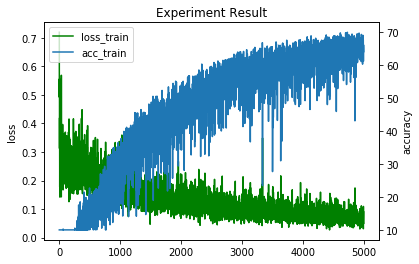

In [37]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [38]:
PATH = './data/CIFAR_noniid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

In [39]:
print(max(acc_train))

70.05
